In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import csv 
import pickle
from scipy import stats
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression

from domino.data.cxr import get_dp, build_cxr_df, get_cxr_activations, rle2mask
import meerkat as mk

In [2]:
dp = mk.DataPanel.read(path="/media/4tb_hdd/siim/gazeslicer_dp_08-18-21.dp")
print(len(dp))
dp.head()

12047


,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),gaze_time (NumpyArrayColumn),gaze_diffusivity (NumpyArrayColumn),expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),input2 (CellColumn),img (CellColumn),gazeslicer_time (NumpyArrayColumn),gazeslicer_time_probs (NumpyArrayColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,False,0.071790
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,True,0.178494
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,False,0.000313
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,True,0.737674
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,NaN,NaN,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,True,0.421900


In [3]:
# get erm activations
#model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-16/14-30-37/wandb/latest-run/files/domino/2796brkc/checkpoints/epoch=49-step=1499.ckpt"
model_pth = "/home/ksaab/Documents/domino/scratch/khaled/results/method_erm/gaze_split_False/target_pmx/subgroup_none/lr_1e-05/wd_0.0/domino/83zostfu/checkpoints/epoch=49-step=17299.ckpt"
# undersample train to remove correlation (on gaze train set)
#model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-06/18-11-35/wandb/latest-run/files/domino/vhcmqiax/checkpoints/epoch=49-step=499.ckpt"
# Undersampled tubes and pleural effusion to remove correlations (on gaze train set)
#model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/2021-08-17/12-22-33/wandb/latest-run/files/domino/u9udzvfs/checkpoints/epoch=49-step=299.ckpt"

dp_erm = get_cxr_activations(dp=dp, model_path=model_pth, run_type="domino")#, num_classes=4)

dp_erm.head()

100%|██████████| 753/753 [02:09<00:00,  5.81it/s]


,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),chest_tube (NumpyArrayColumn),split (NumpyArrayColumn),gaze_seq (NumpyArrayColumn),gaze_heatmap (NumpyArrayColumn),gaze_max_visit (NumpyArrayColumn),gaze_unique (NumpyArrayColumn),...,expert_label (NumpyArrayColumn),index (ListColumn),input (CellColumn),input2 (CellColumn),img (CellColumn),gazeslicer_time (NumpyArrayColumn),gazeslicer_time_probs (NumpyArrayColumn),output (ClassificationOutputColumn),activation_block3 (TensorColumn),activation_block4 (TensorColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,...,NaN,'0',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,False,0.071790,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,...,NaN,'1',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,True,0.178494,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,...,NaN,'2',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,False,0.000313,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,...,NaN,'3',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,True,0.737674,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/media/4tb_hdd/siim/dicom-images-train/1.2.276...,NaN,train,nan,nan,NaN,NaN,...,NaN,'4',MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,MedicalVolumeCell([PosixPath('/media/4tb_hdd/s...,True,0.421900,torch.Tensor(shape=torch.Size([2])),"torch.Tensor(shape=torch.Size([1024, 14, 14]))","torch.Tensor(shape=torch.Size([2048, 7, 7]))"


In [4]:
gaze_name = "gazeslicer_time"

dp_ = dp_erm

train_mask = dp["gaze_seq"].data != "nan"
test_mask = np.logical_and(~train_mask, ~np.isnan(dp["chest_tube"]))

test_probs = dp_[test_mask]["output"].data[:,1].sigmoid()
test_labels = dp_[test_mask]["pmx"].data
print(f"Overall AUROC: {roc_auc_score(test_labels,test_probs):.3f}")

# AUROC performance on subset that has tube labels
gaze_mask = np.array(dp_[test_mask][gaze_name] == 1)
print(f"With {gaze_name} AUROC: {roc_auc_score(test_labels[gaze_mask],test_probs[gaze_mask]):.3f}")

# AUROC performance on subset that has no tube labels
nogaze_mask = np.array(dp_[test_mask][gaze_name] == 0)
print(f"Without {gaze_name} AUROC: {roc_auc_score(test_labels[nogaze_mask],test_probs[nogaze_mask]):.3f}")

neg_mask = np.array(dp_[test_mask]["pmx"] == 0)
pos_mask = np.array(dp_[test_mask]["pmx"] == 1)
gaze_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,gaze_mask))
nogaze_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,nogaze_mask))

print(f"All positives have {gaze_name}, AUROC: {roc_auc_score(test_labels[gaze_in_pos_mask],test_probs[gaze_in_pos_mask]):.3f}")
print(f"All positives have no {gaze_name}, AUROC: {roc_auc_score(test_labels[nogaze_in_pos_mask],test_probs[nogaze_in_pos_mask]):.3f}")

gaze_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,gaze_mask))
nogaze_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,nogaze_mask))

print(f"All negatives have {gaze_name}, AUROC: {roc_auc_score(test_labels[gaze_in_neg_mask],test_probs[gaze_in_neg_mask]):.3f}")
print(f"All negatives have no {gaze_name}, AUROC: {roc_auc_score(test_labels[nogaze_in_neg_mask],test_probs[nogaze_in_neg_mask]):.3f}")

mask = np.logical_or(np.logical_and(pos_mask,nogaze_mask), np.logical_and(neg_mask,gaze_mask))
print(f"All negatives have {gaze_name}, All positives have no {gaze_name}, AUROC: {roc_auc_score(test_labels[mask],test_probs[mask]):.3f}")

Overall AUROC: 0.900
With gazeslicer_time AUROC: 0.795
Without gazeslicer_time AUROC: 0.877
All positives have gazeslicer_time, AUROC: 0.955
All positives have no gazeslicer_time, AUROC: 0.826
All negatives have gazeslicer_time, AUROC: 0.672
All negatives have no gazeslicer_time, AUROC: 0.936
All negatives have gazeslicer_time, All positives have no gazeslicer_time, AUROC: 0.507


## Conditioning on other features

### On chest tubes

In [5]:
newtest_mask = np.array(dp_["chest_tube"] == 1)
newtest_mask = np.logical_and(test_mask,newtest_mask)

test_probs = dp_[newtest_mask]["output"].data[:,1].sigmoid()
test_labels = dp_[newtest_mask]["pmx"].data
print(f"Overall AUROC: {roc_auc_score(test_labels,test_probs):.3f}")

# AUROC performance on subset that has tube labels
gaze_mask = np.array(dp_[newtest_mask][gaze_name] == 1)
print(f"With {gaze_name} AUROC: {roc_auc_score(test_labels[gaze_mask],test_probs[gaze_mask]):.3f}")

# AUROC performance on subset that has no tube labels
nogaze_mask = np.array(dp_[newtest_mask][gaze_name] == 0)
print(f"Without {gaze_name} AUROC: {roc_auc_score(test_labels[nogaze_mask],test_probs[nogaze_mask]):.3f}")

neg_mask = np.array(dp_[newtest_mask]["pmx"] == 0)
pos_mask = np.array(dp_[newtest_mask]["pmx"] == 1)
gaze_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,gaze_mask))
nogaze_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,nogaze_mask))

print(f"All positives have {gaze_name}, AUROC: {roc_auc_score(test_labels[gaze_in_pos_mask],test_probs[gaze_in_pos_mask]):.3f}")
print(f"All positives have no {gaze_name}, AUROC: {roc_auc_score(test_labels[nogaze_in_pos_mask],test_probs[nogaze_in_pos_mask]):.3f}")

gaze_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,gaze_mask))
nogaze_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,nogaze_mask))

print(f"All negatives have {gaze_name}, AUROC: {roc_auc_score(test_labels[gaze_in_neg_mask],test_probs[gaze_in_neg_mask]):.3f}")
print(f"All negatives have no {gaze_name}, AUROC: {roc_auc_score(test_labels[nogaze_in_neg_mask],test_probs[nogaze_in_neg_mask]):.3f}")

mask = np.logical_or(np.logical_and(pos_mask,nogaze_mask), np.logical_and(neg_mask,gaze_mask))
print(f"All negatives have {gaze_name}, All positives have no {gaze_name}, AUROC: {roc_auc_score(test_labels[mask],test_probs[mask]):.3f}")

Overall AUROC: 0.770
With gazeslicer_time AUROC: 0.705
Without gazeslicer_time AUROC: 0.799
All positives have gazeslicer_time, AUROC: 0.843
All positives have no gazeslicer_time, AUROC: 0.654
All negatives have gazeslicer_time, AUROC: 0.605
All negatives have no gazeslicer_time, AUROC: 0.886
All negatives have gazeslicer_time, All positives have no gazeslicer_time, AUROC: 0.446


### on abnormal area

In [6]:
abn_size = np.array([rle2mask(rle,1024,1024).mean() if rle!='-1' else 0 for rle in dp_["encoded_pixels"]])

pos_mask = np.array(dp_["pmx"] == 1)
newtest_mask = np.logical_and(pos_mask,abn_size < 0.007)
newtest_mask = np.logical_and(test_mask,newtest_mask)


test_preds = dp_[newtest_mask]["output"].data[:,1].sigmoid() > 0.5
test_labels = dp_[newtest_mask]["pmx"].data

print(f"Overall recall ({len(test_labels)}): {accuracy_score(test_labels,test_preds):.3f}")

# AUROC performance on subset that has tube labels
gaze_mask = np.array(dp_[newtest_mask][gaze_name] == 1)
print(f"With {gaze_name} recall ({len(test_labels[gaze_mask])}): {accuracy_score(test_labels[gaze_mask],test_preds[gaze_mask]):.3f}")

# AUROC performance on subset that has no tube labels
nogaze_mask = np.array(dp_[newtest_mask][gaze_name] == 0)
print(f"Without {gaze_name} recall ({len(test_labels[nogaze_mask])}): {accuracy_score(test_labels[nogaze_mask],test_preds[nogaze_mask]):.3f}")

Overall recall (122): 0.508
With gazeslicer_time recall (76): 0.684
Without gazeslicer_time recall (46): 0.217


In [7]:
tube_nogaze_mask = np.logical_and(dp_[newtest_mask][gaze_name] == 1, dp_[newtest_mask]["chest_tube"]==1)
print(tube_nogaze_mask.sum()/(dp_[newtest_mask][gaze_name] == 1).sum())

0.8026315789473685


In [8]:
tube_nogaze_mask = np.logical_and(dp_[test_mask][gaze_name] == 1, dp_[test_mask]["chest_tube"]==1)
print(tube_nogaze_mask.sum()/(dp_[test_mask][gaze_name] == 1).sum())

0.5975609756097561


In [9]:
print((dp_[newtest_mask]["chest_tube"]==1).sum()/len(dp_[newtest_mask]))

0.7540983606557377


In [10]:
len(abn_size)

12047

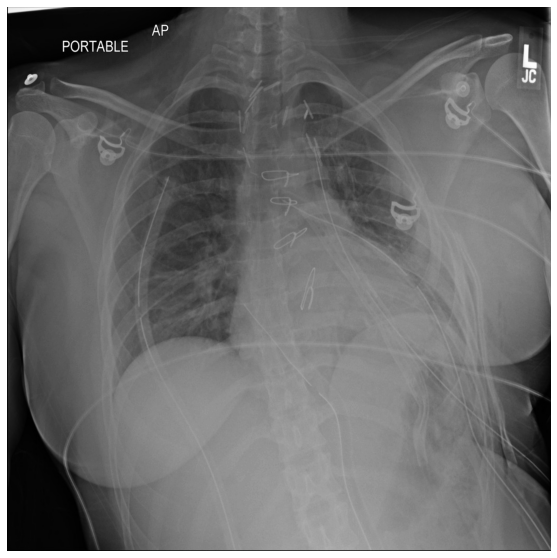

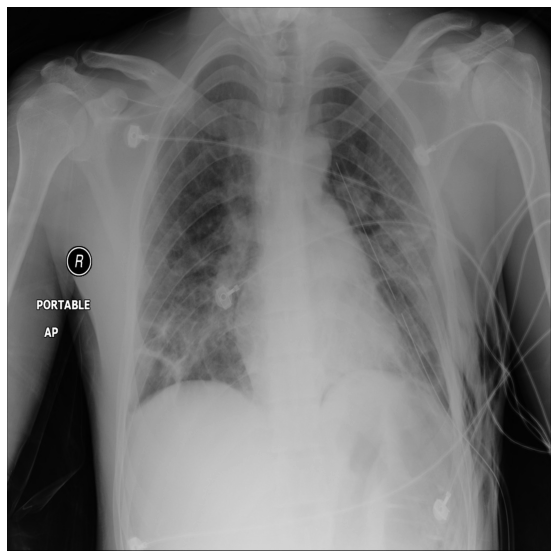

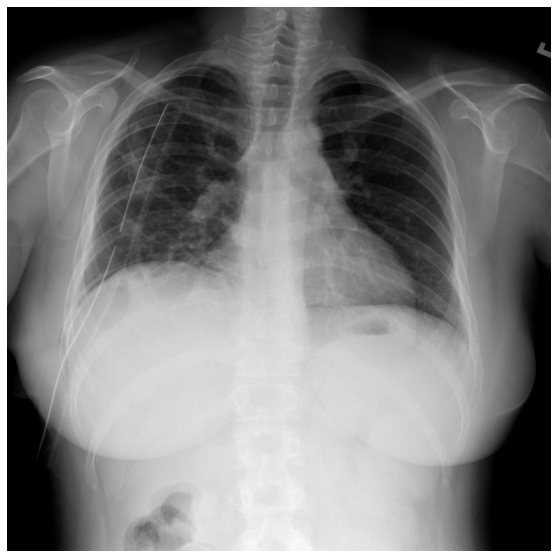

In [11]:
num_images = 2
nn = 0
for row in dp_[newtest_mask]:
    if row[gaze_name] == 0:
        img = row["img"]
        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap='gray')
        plt.axis("OFF")
        plt.show()
        nn+=1

    if nn > num_images:
        break

## Mimic

In [12]:
# get mimic activations
model_pth = "/home/ksaab/Documents/domino/scratch/khaled/outputs/08-10_sabri_mimic/model_chkpt_runid4495.pt"
dp_mimic = get_cxr_activations(dp=dp, model_path=model_pth, run_type="mimic")


100%|██████████| 753/753 [02:05<00:00,  6.01it/s]


In [13]:
mimic_labels = [
    "atelectasis",
    "cardiomegaly",
    "consolidation",
    "edema",
    "enlarged_cardio",
    "fracture",
    "lung_opacity",
    "pleural_effusion",
    "pleural_other",
    "pneumonia",
    "pneumothorax",
    "support_devices",
    "lung_lesion",
    "no_finding",
]

test_mimic_probs = dp_mimic[test_mask]["output"].data.softmax(1)
test_mimic_probs[:,11] = 0 # remove support devices
test_mimic_probs[:,10] = 0 # remove pmx
test_mimic_probs[:,-1] = 0 # remove no finding

test_mimic_preds = test_mimic_probs.argmax(1)

In [14]:
label_mask = np.array(dp_[test_mask]["pmx"] == 0)
slicing_pred = dp_mimic[test_mask][gaze_name]

In [15]:
for ndx in range(len(mimic_labels)):
    if (test_mimic_preds[label_mask]==ndx).sum() > 50:
        print(f"{mimic_labels[ndx]} Count: {(test_mimic_preds[label_mask]==ndx).sum()}, AUROC: {roc_auc_score(slicing_pred[label_mask],test_mimic_probs[label_mask,ndx]):.3f}")

atelectasis Count: 55, AUROC: 0.636
cardiomegaly Count: 184, AUROC: 0.556
lung_opacity Count: 331, AUROC: 0.617
pleural_effusion Count: 121, AUROC: 0.677


In [23]:
slice_mask = np.array(slicing_pred == 1)
mask = np.logical_and(label_mask,slice_mask)
print(f"Overall {gaze_name} count: {slicing_pred.sum()}\n")
for ndx in range(len(mimic_labels)):
    print(f"{mimic_labels[ndx]} Count %: {(test_mimic_preds[mask]==ndx).sum()/mask.sum():.2f}")

Overall gazeslicer_time count: 246

atelectasis Count %: 0.08
cardiomegaly Count %: 0.14
consolidation Count %: 0.00
edema Count %: 0.00
enlarged_cardio Count %: 0.00
fracture Count %: 0.00
lung_opacity Count %: 0.44
pleural_effusion Count %: 0.30
pleural_other Count %: 0.00
pneumonia Count %: 0.00
pneumothorax Count %: 0.00
support_devices Count %: 0.00
lung_lesion Count %: 0.04
no_finding Count %: 0.00
